In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install s3fs

import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re
import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

import keras
from keras.utils import np_utils
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge
from keras.layers import Input, Dense, Activation, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold

import s3fs

import time
import datetime
from data_helpers_v7_out_of_bag import load_data, clean_str, text_preprocessing, label_processing, evaluation, ints2setences
from tensorflow.contrib import learn
import tensorflow as tf

# data preparation --------------------------------------------

NUM_SUMPLE = 6000
MAX_LEN_DOC = 70
MAX_NB_WORDS = 200000
URL1 = '../data/train1800.csv'
URL2 = '../data/test1800.csv'
TEXT_TITLE_COMBINED = True

x, y, split_index, vocab_size, id2word, word2id, pre_x, pre_data, labelEncoder = load_data(
    MAX_LEN_DOC=MAX_LEN_DOC, NUM_SUMPLE=NUM_SUMPLE, MAX_NB_WORDS=MAX_NB_WORDS,
    url1=URL1, url2=URL2, TEXT_TITLE_COMBINED=TEXT_TITLE_COMBINED)

Using TensorFlow backend.


Loading data...
Clean up texts...
Tokenizing...
Integer encoding...
Padding...


In [2]:
pre_x_train, pre_x_test = pre_x.iloc[0:split_index], pre_x.iloc[split_index:]

In [3]:
def kfold_generator(X, y, data, n):
    kf = KFold(n_splits=n, random_state = 7)
    result = []
    i = 0
    for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pre_data_train, pre_data_test = data.iloc[train_index], data.iloc[test_index]
        result.append([X_train, X_test, y_train, y_test, pre_data_train, pre_data_test])
        i +=1
        
    return result

In [4]:
def generate_embed_index():
    embeddings_index = {}
    f = open('../word_vector/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index

In [5]:
# parameters --------------------------------------------------

sequence_length = x.shape[1]
vocabulary_size = vocab_size
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5
num_class = y.shape[1]
embedding_dim = 100
epochs = 1
batch_size = 32
# --------------------------------------------------------------

def model_generator(embeddings_index):
    embedding_matrix = np.zeros((len(word2id) + 1, embedding_dim))
    for word, i in word2id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, 
                          output_dim=embedding_dim,
                          weights = [embedding_matrix], #### use pre-trained word vector
                          trainable = False,  #### use pre-trained word vector
                          input_length=sequence_length)(inputs)
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=num_class, activation='softmax')(dropout)

    # this creates a model that includes
    return Model(inputs=inputs, outputs=output)


def check_sample(pre_x, post_x, sampl_num, id2word):
#     print ('\n{} Original x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_x.iloc[sampl_num])
#     print ('\n{} Original title #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['title'].iloc[sampl_num])
#     print ('\n{} Original text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['text'].iloc[sampl_num])
#     print ('\n{} Processed x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (post_x[sampl_num])
    print ('\n{} Reverted x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
    print (ints2setences(post_x[sampl_num], id2word))

def error_analysis(y_pred, y_test, pre_x, post_x, id2word, num_errors):
    for item in np.where(y_pred != y_test):
        for i, idx in enumerate (item):
            if i < num_errors:
                print("----------------------------idx {}, prediction {}, test {} ----------------------------------".format(
                    idx, y_pred[idx], y_test[idx]))
                print ("prediction----{}".format(labelEncoder.inverse_transform(y_pred)[idx]))
                print ("test----------{}".format(labelEncoder.inverse_transform(y_test)[idx]))
                print("---"*30)
                print (check_sample(pre_x=pre_x, post_x=post_x, sampl_num=idx, id2word=id2word))
                
def model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word):
    model = model_generator(embeddings_index)

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # try categorical_crossentropy?

    history = model.fit(x_train, y_train, 
              batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

    # evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict(x_test)
    evaluation(y_pred=y_pred.argmax(-1), y_test=y_test.argmax(-1), history=history)
    error_analysis(y_pred.argmax(-1), y_test.argmax(-1), pre_x_test, x_test, id2word, 5)
    
    return (y_pred)

In [6]:
def truncating(text):
    result = []
    for i, word in enumerate(text.split(" ")):
        if i < 70:
            result.append(word)
    
    return " ".join(result)

def generate_template(y_test, y_pred, pre_x_test, labelEncoder):
    
    print (pre_x_test.shape)
    pre_x_test.reset_index()
    pre_x_test = pd.DataFrame(pre_x_test)
    pre_x_test['Test_label'] = labelEncoder.inverse_transform(y_test)
    pre_x_test['Predict_label'] = labelEncoder.inverse_transform(y_pred)
    
    for item in np.where(y_pred != y_test):
        error_data = pre_x_test.iloc[item]
        
    # truncate
    error_data.loc[:,'text'] = error_data.loc[:,'text'].map(str).apply(truncating)
    
    del pre_x_test
    
    return error_data

In [7]:
embeddings_index = generate_embed_index()

data_sets = kfold_generator(x, y, pre_data, 4)

Found 400000 word vectors.


Train on 10214 samples, validate on 1135 samples
Epoch 1/1
10214/10214 [==============================] - 55s 5ms/step - loss: 2.5978 - acc: 0.2109 - val_loss: 1.4334 - val_acc: 0.5833
acc: 56.18%
---------Confusion Matrix Report -------------------- 

[[  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0 135  36  20  29  35  29   9  90  40]
 [  0   0   0   3 320   4  11  15  11  12  27   9]
 [  0   0   0  21  91  72  52  21  92   6  39  17]
 [  0   0   0  23  41   9 208  74  30  16   8  38]
 [  0   0   0  13  17   3  40 273   8   5  10  34]
 [  0   0   0  16  41  12  14  12 305   0  19  12]
 [  0   0   0   5  29   6  11   8   2 341  12  14]
 [  0   0   0  27  34   6  10  12  40   2 279  10]
 [  0   0   0  29  24   1  44  49  32  15  19 193]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          1       0.00 

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


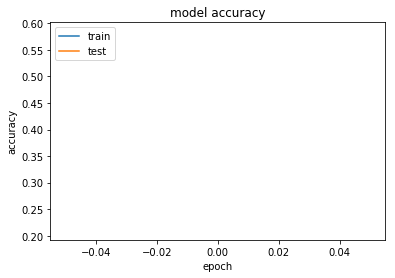

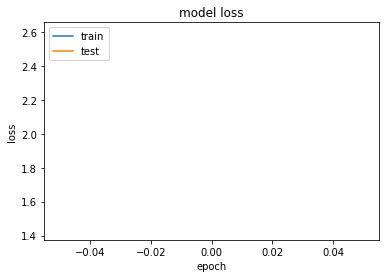

----------------------------idx 0, prediction 17, test 21 ----------------------------------
prediction----EN_US_POLITICS
test----------EN_US_WORLD
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #0 ------------------------------

former uefa general secretary david taylor dies abc news scotland 's football association says former uefa general secretary david taylor has died he was 60 the sfa says taylor 's death was confirmed by uefa where he worked as chief executive of its commercial operations in a statement on its website the scottish body says its former chief executive had fallen ill though no details were given sfa president campbell
None
----------------------------idx 2, prediction 13, test 20 ----------------------------------
prediction----EN_US_BUSINESS
test----------EN_US_TECHNOLOGY
------------------------------------------------------------------------------------------

---------

In [8]:
x_train = data_sets[0][0] # x_train
x_test = data_sets[0][1] # x_test
y_train = data_sets[0][2] # y_train
y_test = data_sets[0][3] # y_test
pre_data_train = data_sets[0][4] # pre_data_train
pre_data_test = data_sets[0][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)

In [9]:
error_data1 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data1)))
print (error_data1.head(10))

(3784, 6)
error data has 1658 rows
                                                title             category  \
0   Former UEFA General Secretary David Taylor Die...          EN_US_WORLD   
2   Hungary plans to impose new tax on Internet tr...     EN_US_TECHNOLOGY   
3    Hope Solo Arrested for Domestic Violence Against       EN_US_NATIONAL   
6   Governor-General David Johnston's Remembrance ...       EN_US_POLITICS   
10  Romanian 'Orthodox Priests' Calendar 2015 Pays...          EN_US_WORLD   
11  Can vegans stomach the unpalatable truth about...       EN_US_BUSINESS   
13                        Dominic Cizauskas sentenced         EN_US_SPORTS   
14  Netanyahu blasts international court over prel...       EN_US_NATIONAL   
16          Nutrition: in Sierra Leone breast is best          EN_US_WORLD   
17  Author Compares Women in Traditional Marriages...  EN_US_ENTERTAINMENT   

                                                 text  \
0   Scotland's Football Association says former U

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 10215 samples, validate on 1135 samples
Epoch 1/1
10215/10215 [==============================] - 56s 5ms/step - loss: 2.6316 - acc: 0.2046 - val_loss: 1.4548 - val_acc: 0.5665
acc: 55.72%
---------Confusion Matrix Report -------------------- 

[[  0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0]
 [  0   0 262  10  45   8  17  15  13  33  19]
 [  0   0  35 205  55  19  11  10  44  10   7]
 [  0   0  87  34 157  19  14  70  20  17  14]
 [  0   0  68   8  35 154  70  25  30   2  42]
 [  0   0  44  10  10  21 263  11  14   4  53]
 [  0   0  41  10  28   6   7 274   6  14  14]
 [  0   0  15   5  12   4   3   0 349   7   2]
 [  0   0 117  12  37   2   4  45   9 206   7]
 [  0   0  65   8  23  24  24  18  24   7 238]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         1
         13 

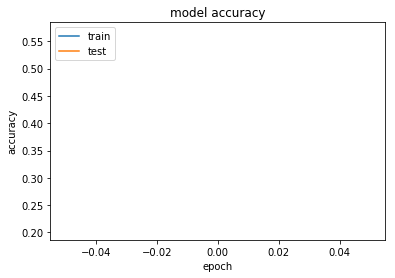

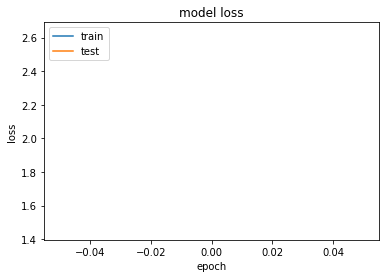

----------------------------idx 3, prediction 20, test 17 ----------------------------------
prediction----EN_US_TECHNOLOGY
test----------EN_US_POLITICS
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #3 ------------------------------

irs calling nope it 's a scam all rights reserved cell phones desktops digital cameras laptops printers tablets televisions first the bad news americans are terrible at recognizing bogus emails until it 's too late but even corporations with seemingly sophisticated security checks in place can fall victim to hackers last week 's coordinated attacks that hit at least five us banks offered another expensive reminder of how little we
None
----------------------------idx 5, prediction 17, test 16 ----------------------------------
prediction----EN_US_POLITICS
test----------EN_US_NATIONAL
----------------------------------------------------------------------------------

In [10]:
x_train = data_sets[1][0] # x_train
x_test = data_sets[1][1] # x_test
y_train = data_sets[1][2] # y_train
y_test = data_sets[1][3] # y_test
pre_data_train = data_sets[1][4] # pre_data_train
pre_data_test = data_sets[1][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)

In [11]:
error_data2 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data2)))
print (error_data2.head(10))

(3783, 6)
error data has 1675 rows
                                                  title          category  \
3787                     IRS calling? Nope. It's a scam    EN_US_POLITICS   
3789  Watch What Happens When Will Cain and Whoopi G...    EN_US_NATIONAL   
3791  Whaling ruling helps to clarify what counts as...     EN_US_SCIENCE   
3792  U.S. sovereign group's leader convicted of sel...    EN_US_POLITICS   
3795    Ladyfag Is the Rave of the Future - NYTimes.com   EN_US_LIFESTYLE   
3796  How Your Company -- And Your Job -- Will Soon ...    EN_US_BUSINESS   
3797               CDC: States With Highest Birth Rates     EN_US_SCIENCE   
3800                  Where Do Recycled Electronics Go?  EN_US_TECHNOLOGY   
3801  Police kill suspect after 2 injured at Hon-Dah...    EN_US_NATIONAL   
3805  Union Budget 2015: Jaitley dumps Rs 1,000 cror...       EN_US_WORLD   

                                                   text  \
3787  All Rights Reserved.                  Cell Pho...   

Train on 10215 samples, validate on 1135 samples
Epoch 1/1
10215/10215 [==============================] - 55s 5ms/step - loss: 2.5701 - acc: 0.2145 - val_loss: 1.4343 - val_acc: 0.5630
acc: 55.70%
---------Confusion Matrix Report -------------------- 

[[  0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   0 128  31  24  34  57  19   5  89  35]
 [  0   0   5 332  10  15  27  17   6  20   7]
 [  0   0  24  84 107  51  29  82   3  35  19]
 [  0   0  12  32  11 181  84  22   6   8  27]
 [  0   0  10  20   6  33 285   6   2   9  50]
 [  0   0   8  11  11  20  15 324   0  22  12]
 [  0   0   4  41   0  22  26   5 294  16  23]
 [  0   0  33  26  12  18  14  39   1 255   8]
 [  0   0  25  24   6  37  63  27  21  18 201]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1
         13 

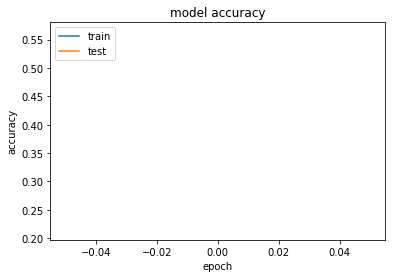

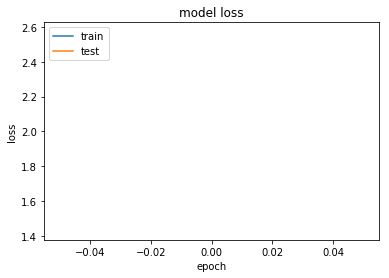

----------------------------idx 3, prediction 19, test 16 ----------------------------------
prediction----EN_US_SPORTS
test----------EN_US_NATIONAL
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #3 ------------------------------

world cup 2014 keshi hits back at okocha comments 24 june 2014 last updated at 10 08 share this page world cup 2014 keshi hits back at okocha comments nigeria coach stephen keshi has hit back at criticism of his world cup tactics from former super eagles captain jay jay okocha people have a right to their opinions but some people enjoy being destructive said keshi when people who should
None
----------------------------idx 6, prediction 21, test 16 ----------------------------------
prediction----EN_US_WORLD
test----------EN_US_NATIONAL
------------------------------------------------------------------------------------------

------------------------------ Reverted x_

In [12]:
x_train = data_sets[2][0] # x_train
x_test = data_sets[2][1] # x_test
y_train = data_sets[2][2] # y_train
y_test = data_sets[2][3] # y_test
pre_data_train = data_sets[2][4] # pre_data_train
pre_data_test = data_sets[2][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)
error_data3 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data3)))
print (error_data3.head(10))

Train on 10215 samples, validate on 1135 samples
Epoch 1/1
10215/10215 [==============================] - 56s 5ms/step - loss: 2.6119 - acc: 0.2062 - val_loss: 1.4314 - val_acc: 0.5912
acc: 58.52%
---------Confusion Matrix Report -------------------- 

[[  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  99  19  51  18  33  24  27  99  43]
 [  0   0   0   0   0   0   0 290  25  19  10   9  36  25  19]
 [  0   0   0   0   0   0   3  60 144  21  22  63  20  47  23]
 [  0   0   0   0   0   0   6  12  24 180  76  34  30  14  40]
 [  0   0   0   0   0   0   7  14  15  27 281  16   6  18  42]
 [  0   0   0   0   0   0   2   8  28  12   7 295   4 

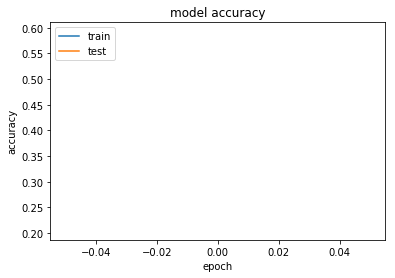

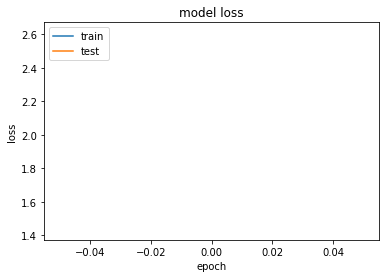

----------------------------idx 0, prediction 18, test 16 ----------------------------------
prediction----EN_US_SCIENCE
test----------EN_US_NATIONAL
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #0 ------------------------------

unclear washington landslide lawsuits could win abc news the warnings could hardly have been clearer one technical report told of the potential for a large catastrophic failure of the 600 foot hillside above a rural neighborhood near oso on the stillaguamish river another noted plainly that it poses a significant risk to human lives and private property the danger was so apparent that snohomish county officials mulled buying out the
None
----------------------------idx 2, prediction 14, test 15 ----------------------------------
prediction----EN_US_ENTERTAINMENT
test----------EN_US_LIFESTYLE
-----------------------------------------------------------------------------

In [13]:
x_train = data_sets[3][0] # x_train
x_test = data_sets[3][1] # x_test
y_train = data_sets[3][2] # y_train
y_test = data_sets[3][3] # y_test
pre_data_train = data_sets[3][4] # pre_data_train
pre_data_test = data_sets[3][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)
error_data4 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data4)))
print (error_data4.head(10))

In [14]:
error_combined = pd.concat([error_data1, error_data2, error_data3, error_data4])

error_combined.loc[:, ('idx','title', 'text', 'url', 'Test_label', 'Predict_label')].to_csv('error_combined.csv', sep='|', index = False)
print (error_combined.shape)

# make sure there is no duplicate row
error_combined.drop_duplicates(subset=['idx', 'title'], inplace = True)
print (error_combined.shape)

(6578, 8)
(6576, 8)


In [17]:
from io import StringIO
import boto3

def upload_to_s3(bucket, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = 'tmp/data/classification/error_combined.csv'
    s3.Bucket(bucket).put_object(Key=key, Body=data)

bucket = 'smart-newsdev-dmp'

upload_to_s3(bucket,'error_combined.csv')